In [39]:

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
log_path = "/Users/antonkotys/Downloads/BPI Challenge 2017_1_all/BPI Challenge 2017.xes.gz"

event_log = xes_importer.apply(log_path)

df = log_converter.apply(event_log, variant=log_converter.Variants.TO_DATA_FRAME)

df.to_csv("bpi2017.csv", index=False)

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

Loaded 31509 traces


In [3]:
df = pd.read_csv("bpi2017.csv")

In [47]:
num_cases = df['case:concept:name'].nunique()
print(f"Number of cases: {num_cases}")

Number of cases: 31509


In [48]:
num_events = len(df)
print(f"Number of events: {num_events}")

Number of events: 1202267


In [49]:
variants = (
    df.sort_values(['case:concept:name', 'time:timestamp'])
      .groupby('case:concept:name')['concept:name']
      .apply(list)
      .value_counts()
)

num_variants = len(variants)
print(f"Number of process variants: {num_variants}")

Number of process variants: 15930


In [52]:
num_event_labels = df['concept:name'].nunique()
print(f"Number of event labels: {num_event_labels}")

Number of event labels: 26


In [56]:
num_cases = df["case:concept:name"].nunique()

print(f"Number of case labels: {num_cases}")
print("Number of case labels is equivalent to the number of cases, as each case has its own case label case:concept:name ")

Number of case labels: 31509
Number of case labels is equivalent to the number of cases, as each case has its own case label case:concept:name 


In [25]:
categorical_cols = df.select_dtypes(exclude=['number', 'datetime']).columns
print("Categorical event attributes:")
print(categorical_cols)
print(f"\nNumber of categorical event attributes: {len(categorical_cols)}")

Categorical event attributes:
Index(['Action', 'org:resource', 'concept:name', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time:timestamp', 'case:LoanGoal',
       'case:ApplicationType', 'case:concept:name', 'Accepted', 'Selected',
       'OfferID'],
      dtype='object')

Number of categorical event attributes: 13


38.15630454790695
16.71530805656438


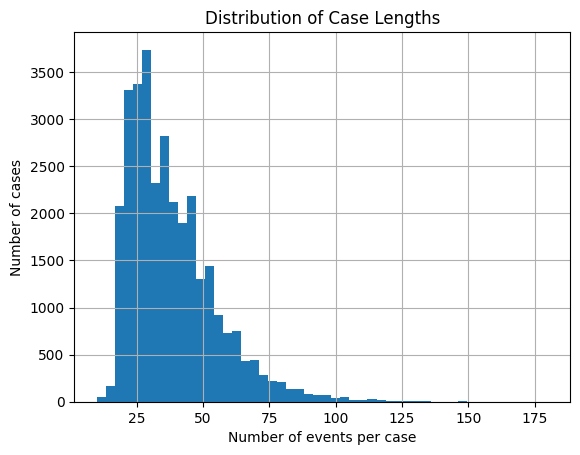

In [54]:
aggregatedAfterCase = df.groupby('case:concept:name').size()

mean_case_length = aggregatedAfterCase.mean()
std_case_length = aggregatedAfterCase.std()

print(mean_case_length)
print(std_case_length)

aggregatedAfterCase.hist(bins=50)
plt.title("Distribution of Case Lengths")
plt.xlabel("Number of events per case")
plt.ylabel("Number of cases")
plt.show()




Mean case duration:
  21.90 days
  31535.43 minutes
  1892125.92 seconds

Standard deviation of case duration:
  13.17 days
  18963.69 minutes
  1137821.69 seconds


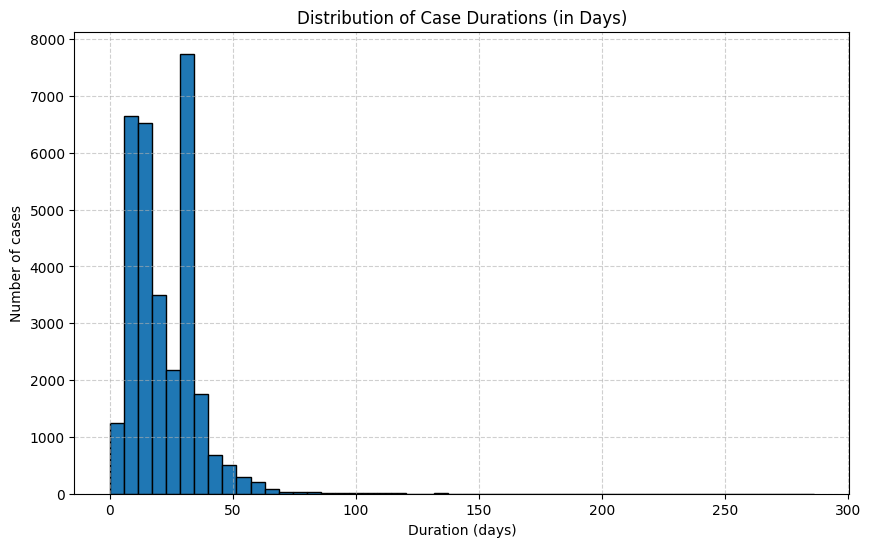

In [60]:
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'], utc=True, errors='coerce', format='mixed')


case_times = (
    df.groupby('case:concept:name')['time:timestamp']
      .agg(['min', 'max'])
      .reset_index()
      .rename(columns={'min': 'start_time', 'max': 'end_time'})
)

case_times['duration'] = case_times['end_time'] - case_times['start_time']

case_times['duration_seconds'] = case_times['duration'].dt.total_seconds()

mean_seconds = case_times['duration_seconds'].mean()
std_seconds = case_times['duration_seconds'].std()

mean_minutes = mean_seconds / 60
std_minutes = std_seconds / 60

mean_days = mean_seconds / (24 * 3600)
std_days = std_seconds / (24 * 3600)

print(f"\nMean case duration:")
print(f"  {mean_days:.2f} days")
print(f"  {mean_minutes:.2f} minutes")
print(f"  {mean_seconds:.2f} seconds")

print(f"\nStandard deviation of case duration:")
print(f"  {std_days:.2f} days")
print(f"  {std_minutes:.2f} minutes")
print(f"  {std_seconds:.2f} seconds")


case_times['duration_days'] = case_times['duration_seconds'] / 86400

plt.figure(figsize=(10, 6))
plt.hist(case_times['duration_days'], bins=50, edgecolor='black')
plt.title("Distribution of Case Durations (in Days)")
plt.xlabel("Duration (days)")
plt.ylabel("Number of cases")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

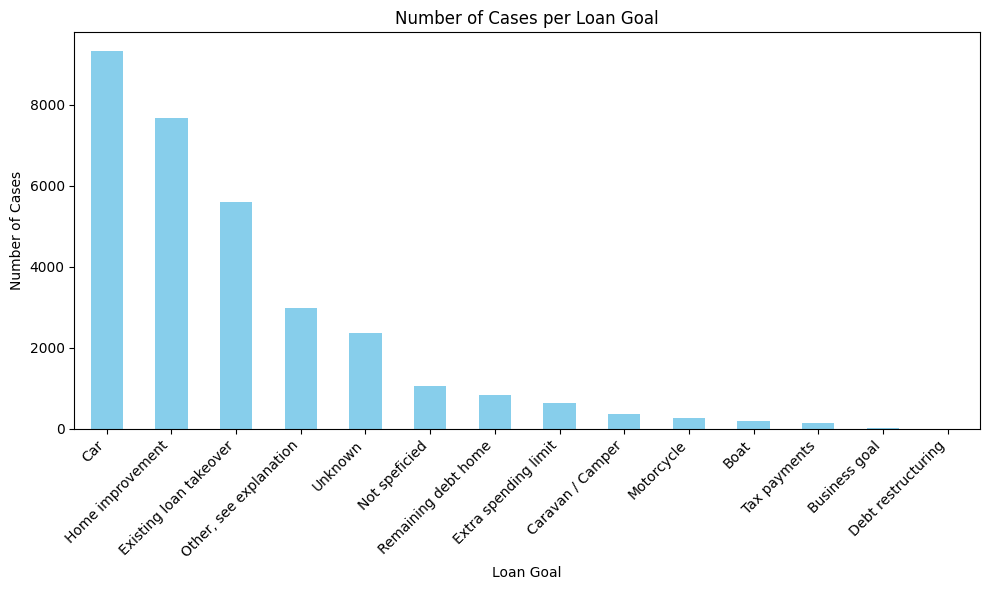

In [65]:
loan_goal_counts = df.groupby("case:LoanGoal")["case:concept:name"].nunique().sort_values(ascending=False)

plt.figure(figsize=(10,6))
loan_goal_counts.plot(kind="bar", color="skyblue")

plt.title("Number of Cases per Loan Goal")
plt.xlabel("Loan Goal")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [71]:

case_groups = df.groupby("case:concept:name")
rework_data = []

for case_id, group in case_groups:
    activities = group["concept:name"].tolist()
    unique_activities = set(activities)
    rework_count = len(activities) - len(unique_activities)
    rework_rate = rework_count / len(activities)
    rework_data.append((case_id, rework_count, rework_rate))

rework_df = pd.DataFrame(rework_data, columns=["case:concept:name", "rework_count", "rework_rate"])

avg_rework_rate = rework_df["rework_rate"].mean()
max_rework = rework_df["rework_count"].max()

print(f"Average rework rate: {avg_rework_rate:.2%}")
print(f"Maximum repeated activities in a single case: {max_rework}")


Average rework rate: 54.68%
Maximum repeated activities in a single case: 163
